This notebook uses the analysis environment (analysis.yml).

In [426]:
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, linregress

from statannotations.Annotator import Annotator
import scienceplots

In [427]:
# Set the style
plt.style.use('science')

plt.rcParams.update({'font.family': 'sans-serif'})

# Get the hex codes for the colors so we can assign them to categories
pal = sns.color_palette('Paired')
print(pal.as_hex())

# Set the color palette. Our categories are "Single Domain", "Two-Domain", and "Autoinhibitory"
pal.as_hex()

['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']


['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']

In [428]:
pal3 = sns.color_palette('PuOr')
pal3.as_hex()

['#c6690c', '#f9b158', '#fce6c8', '#e1e2ee', '#aba3cd', '#664697']

In [429]:
pal6 = sns.color_palette('Blues')
print(pal6.as_hex())
pal6.as_hex()

['#dbe9f6', '#bad6eb', '#89bedc', '#539ecd', '#2b7bba', '#0b559f']


['#dbe9f6', '#bad6eb', '#89bedc', '#539ecd', '#2b7bba', '#0b559f']

In [430]:
pal5 = sns.color_palette('PiYG')

colors = {'Single Domain': pal[0], 'Two-Domain': pal[1], 'Autoinhibitory': pal[3], 'Autoinhibitory (Active)': pal[2], 'Autoinhibitory (Autoinhibited)': pal[3], 
          'Full': pal[3], 'Clusters': pal[7], 'Two-State AI': pal[4], 'Autoinhibitory (Closed)': pal[5], 'Autoinhibitory (Open)': pal[4], 'Obligate': pal[6],
          'Accurate': pal[8], 'Inaccurate': pal[5], 'AI': pal[2], 'TD': pal[0], 'AI UC': pal5[5], 'AI LC': pal5[4], 'TD UC': pal6[3], 'TD LC': pal6[2]}

pal5.as_hex()

['#cf4191', '#eeadd4', '#fbe6f1', '#ebf6db', '#b0dc7d', '#62a32e']

In [431]:
blues = sns.color_palette('Blues')

three_blues = {'Low': blues[1], 'Medium': blues[3], 'High': blues[5]}
greens = sns.color_palette('Greens')

three_greens = {'Low': greens[1], 'Medium': greens[3], 'High': greens[5]}
reds = sns.color_palette('Reds')

three_cats = {'Low': reds[1], 'Medium': reds[3], 'High': reds[5]}

In [432]:
greens.as_hex()

['#e1f3dc', '#bce4b5', '#8ed08b', '#56b567', '#2c944c', '#05712f']

In [433]:
accuracy_palette = {'Accurate TD': blues[2], 'Inaccurate TD': blues[0], 'Accurate AI': greens[2], 'Inaccurate AI': greens[0]}

In [434]:
imfd = '$_{fd}^{im}$RMSD'
grmsd = 'gRMSD'

def string2range(x):
    
    """
    This function takes in a `string` representing a region of interest in a
    protein. The region of interest can be a single region or multiple regions
    of a protein. Returns a range for single regions or a list of ranges for
    multiple regions.
    
    Parameters:
    
        x (string): String containing a region or several regions of interest in a 
            protein.
            Format of x: single region -> 'start-end'
                         multiple regions -> 'start1-end1,start2-end2'
                     
    Returns:
    
        range or list of ranges: For single region proteins a range is returned. For 
            multiple region proteins a list of ranges is returned

            Format: single region -> range(start, end+1)
                    multiple region -> [range(start1, end1+1), range(start2, end2+1)]
    """
    # Handle instances with more than one range
    if ',' in x:
        list_temp = x.split(sep = ',') #list_temp = ['123-456,' '789-1111']
        for y in range(len(list_temp)): 
            list_temp[y] = list_temp[y].split(sep = '-') #list_temp[y] = [['123', '456'], ['789', '1111']]
        for y in range(len(list_temp)): 
            for x in range(len(list_temp[y])):
                list_temp[y][x] = int(list_temp[y][x]) #turns each list item into an integer

        # Make a range object with the bounds of the range. Note to the 
        # end a 1 has to be added in order to include the last position in the range
        for y in range(len(list_temp)): #[1, 2] where 1=[123, 456] and 2=[789, 1111]
            for x in range(len(list_temp[y])): #[123, 456]       
                list_temp[y] = list(range(list_temp[y][x], list_temp[y][x+1]+1)) #list_temp[0][0] = [123], list_temp[0][0+1]+1 or [456] + 1 = [457]
                break

        return list(set([item for sublist in list_temp for item in sublist]))

    # Handle instances with only one range
    else:
        list_temp = x.split(sep = '-')
        for y in range(len(list_temp)):
            list_temp[y] = int(list_temp[y]) #

        # Make a range object with the bounds of the region. Note to the 
        # end a 1 has to be added in order to include the last position in the range
        return list(range(list_temp[0], list_temp[1]+1))

def plot_lineage(df, ax, palette, x, y, hue, order, pairs):

    sns.violinplot(x=x, y=y, hue=hue, data=df, ax=ax, palette=palette, dodge=False)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set(xlabel=None, ylabel=None)
    ax.legend(title_fontsize='14', fontsize='12')

    annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order, hue=hue)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
    annotator.apply_and_annotate()

def plot_normal_lineage(df, ax, palette, x, y, hue, order, pairs, include_hue=True):

    sns.boxplot(x=x, y=y, hue=hue, data=df, ax=ax, palette=palette, dodge=False)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set(xlabel=None, ylabel=None)
    ax.legend(title_fontsize='14', fontsize='12')

    if include_hue == True:
        annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order, hue=hue)
        annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
        annotator.apply_and_annotate()
    else:
        annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order)
        annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
        annotator.apply_and_annotate()
# def plot_lineage(df, ax, palette):

#     subcat_order = ['Mean LS', 'LS Var.', 'Mean \% Seq. \n Completeness', 'LS Max', 'Number of Seqs.']

#     sns.boxplot(x='variable', y='value', hue='type', data=df, ax=ax, palette=palette)
#     ax.set_ylim(-10, 125)
#     ax.set(ylabel=None, xlabel=None)
# #     ax.set_ylabel('Value', fontsize=14)
# #     ax.set_xlabel('Feature', fontsize=14)
#     ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
#     ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
#     ax.legend(title='Accuracy', title_fontsize='14', fontsize='12')

#     pairs = [[('Mean LS', 'Accurate'), ('Mean LS', 'Inaccurate')],
#             [('LS Var.', 'Accurate'), ('LS Var.', 'Inaccurate')],
#             [('Mean \% Seq. \n Completeness', 'Accurate'), ('Mean \% Seq. \n Completeness', 'Inaccurate')],
#             [('LS Max', 'Accurate'), ('LS Max', 'Inaccurate')],
#             [('Number of Seqs.', 'Accurate'), ('Number of Seqs.', 'Inaccurate')]
#             ]

#     annotator = Annotator(ax, pairs, data=df, x='variable', y='value', order=subcat_order, hue='type')
#     annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction='bonferroni')
#     annotator.apply_and_annotate()

def percent_domain_coil1(df):
    df['num_domain_coil'] = df['num_im_helix'] + df['num_fd_helix'] + df['num_im_sheet'] + df['num_fd_sheet']
    df['perc_domains_coil'] = df['num_domain_coil'] / (len(df['pdb residues in region_1']) + len(df['pdb residues in region_2']))

    return df

def percent_domain_coil2(df):
    df['num_domain_coil'] = df['num_im_helix'] + df['num_fd_helix'] + df['num_im_sheet'] + df['num_fd_sheet']
    df['perc_im_coil'] = (df['num_im_helix'] + df['num_im_sheet']) / df['region_1_len']
    df['perc_fd_coil'] = (df['num_fd_helix'] + df['num_fd_sheet']) / df['region_2_len']
    df['perc_domains_coil'] = df['num_domain_coil'] / (df['region_1_len'] + df['region_2_len'])

    return df

In [435]:
# The fifteen proteins of our two-state analysis
fifteen_prots = ['P07038', 'Q8NQJ3', 'P60240', 'P28482', 'P62826',
       'P22681', 'P21333', 'P12931', 'Q9Y6K1', 'P26358', 'P29350', 'P35520',
       'P27577', 'O08967', 'P00579']

In [436]:
nstds = pd.read_csv('./project_pipeline/data/ai_nonstandard_monomers.tsv', sep='\t')
structure = pd.read_csv('./project_pipeline/data/ai_structure_information.tsv', sep='\t')
lineage = pd.read_csv('./project_pipeline/data/ai_lineage_scores.csv')
rmsds = pd.read_csv('./project_pipeline/data/ai_pdb_cluster_compared.tsv', sep='\t')

md_nstds = pd.read_csv('./project_pipeline/data/md_nonstandard_monomers.tsv', sep='\t')
md_struct = pd.read_csv('./project_pipeline/data/md_structure_information.tsv', sep='\t')
md_lineage = pd.read_csv('./project_pipeline/data/md_lineage_scores.csv')
md_rmsds = pd.read_csv('./project_pipeline/data/md_pdb_cluster_compared.tsv', sep='\t')

ai_dockq = pd.read_csv('./project_pipeline/data/ai_pdb_full_depth_dockq.csv').astype('object')
md_dockq = pd.read_csv('./project_pipeline/data/md_pdb_full_depth_dockq.csv').astype('object')

cl = pd.read_csv('./project_pipeline/data/classified_files.tsv', sep='\t')

se = pd.read_csv('./project_pipeline/data/ai_af2_clusters_shannon_entropy.csv')
se['w_n'] = se['w_n'].astype(float)
mdse = pd.read_csv('./project_pipeline/data/md_af2_clusters_shannon_entropy.csv')
mdse['w_n'] = mdse['w_n'].astype(float)

nstds = nstds.rename(columns={'complex_rmsd': grmsd, '2_comp': imfd})
md_nstds = md_nstds.rename(columns={'complex_rmsd': grmsd, '2_comp': imfd})

rmsds = rmsds.rename(columns={'complex_rmsd': grmsd, '2_comp': imfd})
md_rmsds = md_rmsds.rename(columns={'complex_rmsd': grmsd, '2_comp': imfd})

nstds = nstds[['uniprot', 'pdb', grmsd, imfd, 'has_partner', 'num_partners', 'has_nstds', 'has_nplymrs']]

structure = structure.drop(columns=['Unnamed: 0', 'region_1', 'region_2', 'pdb_length', 'chain',
                                    'gt_fn', 'interface_residues', 'number_interface_residues',
                                    'num_interface_hydro', 'num_im_hydro', 'num_fd_hydro',
                                    'num_domains_hydro', 'num_protein_helix',
                                    'num_protein_sheet', 'num_protein_hydro', 'perc_domains_hydro'])

md_nstds = md_nstds[['uniprot', 'pdb', grmsd, imfd, 'has_partner', 'num_partners', 'has_nstds', 'has_nplymrs']]

md_struct = md_struct.drop(columns=['Unnamed: 0', 'region_1', 'region_2', 'pdb_length', 'chain',
                                    'gt_fn', 'interface_residues', 'number_interface_residues',
                                    'num_interface_hydro', 'num_im_hydro', 'num_fd_hydro',
                                    'num_domains_hydro', 'num_protein_helix',
                                    'num_protein_sheet', 'num_protein_hydro', 'perc_domains_hydro'])

In [437]:
md_rmsds['uniprot'].sort_values().unique()

array(['A0A0A0V031', 'A0A0F7R6G7', 'A0A0H2WY27', 'A0A140DJY3',
       'A0A3B6UEQ0', 'D9N168', 'E1K248', 'F2Z6J5', 'G0WVH3', 'H2E7Q8',
       'H6SG27', 'O16025', 'O60729', 'O68880', 'O69275', 'P04807',
       'P04958', 'P0AG30', 'P14677', 'P23687', 'P59676', 'Q51504',
       'Q72AS4', 'Q7KLV9', 'Q8GN86', 'Q941M3', 'Q9I5E6'], dtype=object)

In [438]:
structure = percent_domain_coil1(structure)
md_struct = percent_domain_coil1(md_struct)

structure = structure.drop(columns=['num_domain_coil', 'pdb residues in region_1', 'pdb residues in region_2',
                                    'num_im_helix', 'num_fd_helix', 'num_im_sheet', 'num_fd_sheet'])
md_struct = md_struct.drop(columns=['num_domain_coil', 'pdb residues in region_1', 'pdb residues in region_2',
                                    'num_im_helix', 'num_fd_helix', 'num_im_sheet', 'num_fd_sheet'])

In [439]:
# Select columns of interest
clSub = cl[['uniprot', 'pdb', 'complex_rmsd', '2_aligned', '2_comp']]
clSub['complex_rmsd'] = clSub['complex_rmsd'].astype(float)

min_cl = clSub.groupby('uniprot')['complex_rmsd'].min()
minimum_cl = pd.merge(min_cl, clSub, on=['uniprot', 'complex_rmsd'], how='inner').drop_duplicates(subset=['uniprot'])

minimum_cl.shape

/tmp/ipykernel_1377385/801491458.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clSub['complex_rmsd'] = clSub['complex_rmsd'].astype(float)


(128, 5)

In [440]:
dockq1 = pd.merge(minimum_cl, ai_dockq, on=['uniprot', 'pdb'], how='left').fillna(0)
dockq1 = dockq1[dockq1['capri'] != 0]
dockq_uniprots = dockq1['uniprot'].unique()

## Data Wrangling

In [441]:
all_df = pd.merge(nstds, structure, on=['uniprot', 'pdb'], how='inner')
md_all = pd.merge(md_nstds, md_struct, on=['uniprot', 'pdb'], how='inner')

In [442]:
lineage.head()
lineage['lineage_dif'] = abs(lineage['uniprot_lineage_length'] - lineage['cluster_lineage_length'])
lineage.head()

,uniprot,cluster,cf_filename,uniref,taxonId,uniprot_lineage,cluster_lineage,percent_complete,lineage_score,uniprot_lineage_length,cluster_lineage_length,lineage_dif
0,P07038,U100-001,P07038_U100-001.a3m,UniRef100_A0A6A7YAK2,2608987.0,"[131567, 2759, 33154, 4751, 451864, 4890, 7165...","[131567, 2, 1224, 28211, 356, 2822331, 2822332]",85.000000,1.0,16.0,7.0,9.0
1,P07038,U100-001,P07038_U100-001.a3m,UniRef100_A0A0E3PDB5,38027.0,"[131567, 2759, 33154, 4751, 451864, 4890, 7165...","[131567, 2157, 28890, 2290931, 224756, 94695, ...",84.130435,1.0,16.0,8.0,8.0
2,P07038,U100-001,P07038_U100-001.a3m,UniRef100_W1NSW6,13333.0,"[131567, 2759, 33154, 4751, 451864, 4890, 7165...","[131567, 2759, 33090, 35493, 131221, 3193, 580...",87.717391,2.0,16.0,13.0,3.0
3,P07038,U100-001,P07038_U100-001.a3m,UniRef100_A0A2P8C7I5,1541063.0,"[131567, 2759, 33154, 4751, 451864, 4890, 7165...","[131567, 2, 1783270, 68336, 976, 200643, 19701...",83.369565,1.0,16.0,9.0,7.0
4,P07038,U100-001,P07038_U100-001.a3m,UniRef100_A0A7C4C2M2,2026714.0,"[131567, 2759, 33154, 4751, 451864, 4890, 7165...","[131567, 2157, 1783275, 928852, 1700837]",81.521739,1.0,16.0,5.0,11.0


In [443]:
md_lineage['lineage_dif'] = abs(md_lineage['uniprot_lineage_length'] - md_lineage['cluster_lineage_length'])

In [444]:
lineage = lineage.drop(columns=['cf_filename', 'uniref', 'taxonId', 'uniprot_lineage', 'cluster_lineage'])
rmsds = rmsds[['uniprot', 'pdb', 'cluster', grmsd, imfd]]

md_lineage = md_lineage.drop(columns=['cf_filename', 'uniref', 'taxonId', 'uniprot_lineage', 'cluster_lineage'])
md_rmsds = md_rmsds[['uniprot', 'pdb', 'cluster', grmsd, imfd]]

In [445]:
lineage = lineage[lineage['lineage_score'] != 0]
md_lineage = md_lineage[md_lineage['lineage_score'] != 0]

In [446]:
var = lineage.groupby(['uniprot', 'cluster'])['lineage_dif'].transform('var')
lineage['LS $\Delta$ Var.'] = var
mean = lineage.groupby(['uniprot', 'cluster'])['lineage_dif'].transform('mean')
lineage['Mean LS $\Delta$'] = mean
max = lineage.groupby(['uniprot', 'cluster'])['lineage_dif'].transform('max')
lineage['LS $\Delta$ Max'] = max
count = lineage.groupby(['uniprot', 'cluster'])['lineage_dif'].transform('count')
lineage['Number of Seqs.'] = count
mean_perc = lineage.groupby(['uniprot', 'cluster'])['percent_complete'].transform('mean')
lineage['Mean \% Seq. Completeness'] = mean_perc
lineage = lineage.drop(columns=['lineage_score', 'percent_complete', 'uniprot_lineage_length', 'cluster_lineage_length', 'lineage_dif']).drop_duplicates().reset_index(drop=True)

In [447]:
md_var = md_lineage.groupby(['uniprot', 'cluster'])['lineage_dif'].transform('var')
md_lineage['LS $\Delta$ Var.'] = md_var
md_mean = md_lineage.groupby(['uniprot', 'cluster'])['lineage_dif'].transform('mean')
md_lineage['Mean LS $\Delta$'] = md_mean
md_max = md_lineage.groupby(['uniprot', 'cluster'])['lineage_dif'].transform('max')
md_lineage['LS $\Delta$ Max'] = md_max
md_count = md_lineage.groupby(['uniprot', 'cluster'])['lineage_dif'].transform('count')
md_lineage['Number of Seqs.'] = md_count
md_mean_perc = md_lineage.groupby(['uniprot', 'cluster'])['percent_complete'].transform('mean')
md_lineage['Mean \% Seq. Completeness'] = md_mean_perc
md_lineage = md_lineage.drop(columns=['lineage_score', 'percent_complete', 'uniprot_lineage_length', 'cluster_lineage_length', 'lineage_dif']).drop_duplicates().reset_index(drop=True)

In [448]:
lineage_features = pd.merge(lineage, rmsds, on=['uniprot', 'cluster'], how='inner')
lineage_features = pd.merge(lineage_features, se, on=['uniprot', 'cluster'], how='inner')
non_u = lineage_features[~lineage_features['cluster'].str.contains('U')]
only_u = lineage_features[lineage_features['cluster'].str.contains('U')]

# Group each by uniprot and by cluster and select the pdb per cluster with the lowest grmsd
lineage_features = lineage_features.sort_values(grmsd).groupby(['uniprot', 'cluster']).head(1).reset_index(drop=True)
# Select our fifteen proteins
non_u = non_u.sort_values(grmsd).groupby(['uniprot', 'cluster']).head(1).reset_index(drop=True)
only_u = only_u.sort_values(grmsd).groupby(['uniprot', 'cluster']).head(1).reset_index(drop=True)

lineage_features.shape, non_u.shape, only_u.shape

accurate_non_u = non_u[non_u[grmsd] <= 3]
inaccurate_non_u = non_u[non_u[grmsd] > 3]

In [449]:
md_lineage_features = pd.merge(md_lineage, md_rmsds, on=['uniprot', 'cluster'], how='inner')
md_lineage_features = pd.merge(md_lineage_features, mdse, on=['uniprot', 'cluster'], how='inner')
md_non_u = md_lineage_features[~md_lineage_features['cluster'].str.contains('U')]
md_only_u = md_lineage_features[md_lineage_features['cluster'].str.contains('U')]

# Group each by uniprot and by cluster and select the pdb per cluster with the lowest grmsd
md_lineage_features = md_lineage_features.sort_values(grmsd).groupby(['uniprot', 'cluster']).head(1).reset_index(drop=True)
md_non_u = md_non_u.sort_values(grmsd).groupby(['uniprot', 'cluster']).head(1).reset_index(drop=True)
md_only_u = md_only_u.sort_values(grmsd).groupby(['uniprot', 'cluster']).head(1).reset_index(drop=True)

md_lineage_features.shape, md_non_u.shape, md_only_u.shape

md_accurate_non_u = md_non_u[md_non_u[grmsd] <= 3]
md_inaccurate_non_u = md_non_u[md_non_u[grmsd] > 3]

In [450]:
accurate_only_u = only_u[only_u[grmsd] <= 3]
inaccurate_only_u = only_u[only_u[grmsd] > 3]

md_accurate_only_u = md_only_u[md_only_u[grmsd] <= 3]
md_inaccurate_only_u = md_only_u[md_only_u[grmsd] > 3]

uc_acc_ai = 75 # For everything

uc_inacc_ai = 285 # For everything

uc_acc_td = 208 # For everything

uc_inacc_td = 171 # For everything

lc_acc_ai = 37 # 36 for variance

lc_inacc_ai = 1046 # 955 for variance

lc_acc_td = 102 # 94 for variance

lc_inacc_td = 1621 # 1451 for variance

In [451]:
acc_ai_uc = 'Accurate AI \n (n=63)'
inacc_ai_uc = 'Inaccurate AI \n (n=237)'
acc_td_uc = 'Accurate TD \n (n=208)'
inacc_td_uc = 'Inaccurate TD \n (n=171)'

acc_ai_lc = 'Accurate AI \n LC (n=9)'
inacc_ai_lc = 'Inaccurate AI \n LC (n=17)'
acc_td_lc = 'Accurate TD \n LC (n=5)'
inacc_td_lc = 'Inaccurate TD \n LC (n=37)'

# I am putting the number of each category within the labels
accurate_only_u['Accuracy'] = acc_ai_uc
accurate_only_u['Type'] = 'AI UC'
inaccurate_only_u['Accuracy'] = inacc_ai_uc
inaccurate_only_u['Type'] = 'AI UC'

md_accurate_only_u['Accuracy'] = acc_td_uc
md_accurate_only_u['Type'] = 'TD UC'
md_inaccurate_only_u['Accuracy'] = inacc_td_uc
md_inaccurate_only_u['Type'] = 'TD UC'

accurate_non_u['Accuracy'] = acc_ai_lc
accurate_non_u['Type'] = 'AI LC'
inaccurate_non_u['Accuracy'] = inacc_ai_lc
inaccurate_non_u['Type'] = 'AI LC'

md_accurate_non_u['Accuracy'] = acc_td_lc
md_accurate_non_u['Type'] = 'TD LC'
md_inaccurate_non_u['Accuracy'] = inacc_td_lc
md_inaccurate_non_u['Type'] = 'TD LC' 

only_u_ai = pd.concat([accurate_only_u, inaccurate_only_u]).fillna(0)
only_u_md = pd.concat([md_accurate_only_u, md_inaccurate_only_u]).fillna(0)
non_u_ai = pd.concat([accurate_non_u, inaccurate_non_u]).fillna(0)
non_u_md = pd.concat([md_accurate_non_u, md_inaccurate_non_u]).fillna(0)
only_u = pd.concat([only_u_ai, only_u_md])
non_u = pd.concat([non_u_ai, non_u_md])

/tmp/ipykernel_1377385/4207657833.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accurate_only_u['Accuracy'] = acc_ai_uc
/tmp/ipykernel_1377385/4207657833.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accurate_only_u['Type'] = 'AI UC'
/tmp/ipykernel_1377385/4207657833.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [452]:
acc_ai_u10 = 'Accurate AI \n U10 (n=23)'
inacc_ai_u10 = 'Inccurate AI \n U10 (n=127)'
acc_td_u10 = 'Accurate TD \n U10 (n=81)'
inacc_td_u10 = 'Inaccurate TD \n U10 (n=109)'

acc_ai_u100 = 'Accurate AI \n U100 (n=34)'
inacc_ai_u100 = 'Inaccurate AI \n U100 (n=116)'
acc_td_u100 = 'Accurate TD \n U100 (n=128)'
inacc_td_u100 = 'Inaccurate TD \n U100 (n=62)'

accurate_only_u10 = accurate_only_u[accurate_only_u['cluster'].str.contains('U10-')].reset_index(drop=True)
accurate_only_u10['Accuracy'] = acc_ai_u10
accurate_only_u100 = accurate_only_u[accurate_only_u['cluster'].str.contains('U100-')].reset_index(drop=True)
accurate_only_u100['Accuracy'] = acc_ai_u100

inaccurate_only_u10 = inaccurate_only_u[inaccurate_only_u['cluster'].str.contains('U10-')].reset_index(drop=True)
inaccurate_only_u10['Accuracy'] = inacc_ai_u10
inaccurate_only_u100 = inaccurate_only_u[inaccurate_only_u['cluster'].str.contains('U100-')].reset_index(drop=True)
inaccurate_only_u100['Accuracy'] = inacc_ai_u100

md_accurate_only_u10 = md_accurate_only_u[md_accurate_only_u['cluster'].str.contains('U10-')].reset_index(drop=True)
md_accurate_only_u10['Accuracy'] = acc_td_u10
md_accurate_only_u100 = md_accurate_only_u[md_accurate_only_u['cluster'].str.contains('U100-')].reset_index(drop=True)
md_accurate_only_u100['Accuracy'] = acc_td_u100

md_inaccurate_only_u10 = md_inaccurate_only_u[md_inaccurate_only_u['cluster'].str.contains('U10-')].reset_index(drop=True)
md_inaccurate_only_u10['Accuracy'] = inacc_td_u10
md_inaccurate_only_u100 = md_inaccurate_only_u[md_inaccurate_only_u['cluster'].str.contains('U100-')].reset_index(drop=True)
md_inaccurate_only_u100['Accuracy'] = inacc_td_u100

broken_down_by_u_ai = pd.concat([accurate_only_u10, inaccurate_only_u10, accurate_only_u100, inaccurate_only_u100])
broken_down_by_u_md = pd.concat([md_accurate_only_u10, md_inaccurate_only_u10, md_accurate_only_u100, md_inaccurate_only_u100])

only_u_ai_100 = pd.concat([accurate_only_u100, inaccurate_only_u100])
only_u_md_100 = pd.concat([md_accurate_only_u100, md_inaccurate_only_u100])

only_100 = pd.concat([only_u_ai_100, only_u_md_100])

In [453]:
non_u_ai_100 = non_u_ai[non_u_ai['nseq'] >= 100]
non_u_md_100 = non_u_md[non_u_md['nseq'] >= 100]

non_u_100 = pd.concat([non_u_ai_100, non_u_md_100])

In [454]:
both_clusters = pd.concat([only_u_ai_100, non_u_ai_100, only_u_md_100, non_u_md_100])

### Mean Shannon Entropy for all

/tmp/ipykernel_1377385/2825757355.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
/home/bjechow/anaconda3/envs/analysis/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/bjechow/anaconda3/envs/analysis/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/bjechow/anaconda3/envs/analysis/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/bjec

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Accurate AI 
 U100 (n=34)_AI UC vs. Inaccurate AI 
 U100 (n=116)_AI UC: Mann-Whitney-Wilcoxon test two-sided, P_val:9.662e-01 U_stat=3.139e+03
Accurate AI 
 LC (n=9)_AI LC vs. Inaccurate AI 
 LC (n=17)_AI LC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.059e-01 U_stat=1.070e+02
Accurate TD 
 U100 (n=128)_TD UC vs. Inaccurate TD 
 U100 (n=62)_TD UC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.144e-05 U_stat=2.408e+03
Accurate TD 
 LC (n=5)_TD LC vs. Inaccurate TD 
 LC (n=37)_TD LC: Mann-Whitney-Wilcoxon test two-sided, P_val:9.592e-04 U_stat=1.700e+02


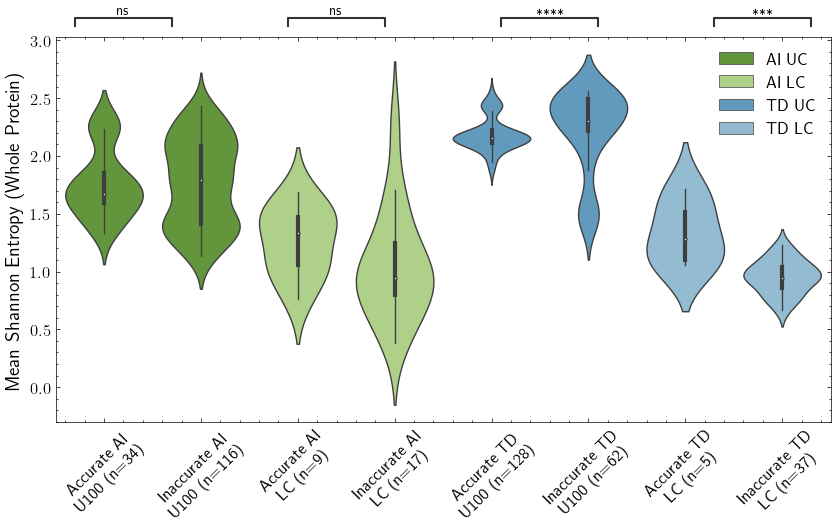

In [455]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))

order1 = [acc_ai_u100, inacc_ai_u100, acc_ai_lc, inacc_ai_lc, acc_td_u100, inacc_td_u100, acc_td_lc, inacc_td_lc]
pairs1 = [[(acc_ai_u100, 'AI UC'), (inacc_ai_u100, 'AI UC')],
          [(acc_ai_lc, 'AI LC'), (inacc_ai_lc, 'AI LC')], 
         [(acc_td_u100, 'TD UC'), (inacc_td_u100, 'TD UC')],
         [(acc_td_lc, 'TD LC'), (inacc_td_lc, 'TD LC')]]

order2 = [acc_ai_lc, inacc_ai_lc, acc_td_lc, inacc_td_lc]
pairs2 = [[(acc_ai_lc, 'AI LC'), (inacc_ai_lc, 'AI LC')],
            [(acc_td_lc, 'TD LC'), (inacc_td_lc, 'TD LC')]]

plot_lineage(both_clusters, axes, colors, 'Accuracy', 'w_mean', 'Type', order1, pairs1)
# plot_lineage(non_u, axes[1], colors, 'Accuracy', 'w_mean', 'Type', order2, pairs2)
axes.set_ylabel('Mean Shannon Entropy (Whole Protein)', fontsize=14)

plt.savefig('./project_pipeline/data/figures/paper/whole_protein_shannon_entropy.png', dpi=1200, bbox_inches='tight')

### Mean Shannon Entropy for nseqs >= 100, Both Domains

/tmp/ipykernel_1377385/2825757355.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
/home/bjechow/anaconda3/envs/analysis/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/bjechow/anaconda3/envs/analysis/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/bjechow/anaconda3/envs/analysis/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/bjec

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Accurate AI 
 U100 (n=34)_AI UC vs. Inaccurate AI 
 U100 (n=116)_AI UC: Mann-Whitney-Wilcoxon test two-sided, P_val:5.375e-06 U_stat=4.523e+03
Accurate AI 
 LC (n=9)_AI LC vs. Inaccurate AI 
 LC (n=17)_AI LC: Mann-Whitney-Wilcoxon test two-sided, P_val:3.556e-02 U_stat=1.160e+02
Accurate TD 
 U100 (n=128)_TD UC vs. Inaccurate TD 
 U100 (n=62)_TD UC: Mann-Whitney-Wilcoxon test two-sided, P_val:4.433e-04 U_stat=2.719e+03
Accurate TD 
 LC (n=5)_TD LC vs. Inaccurate TD 
 LC (n=37)_TD LC: Mann-Whitney-Wilcoxon test two-sided, P_val:5.972e-04 U_stat=1.720e+02


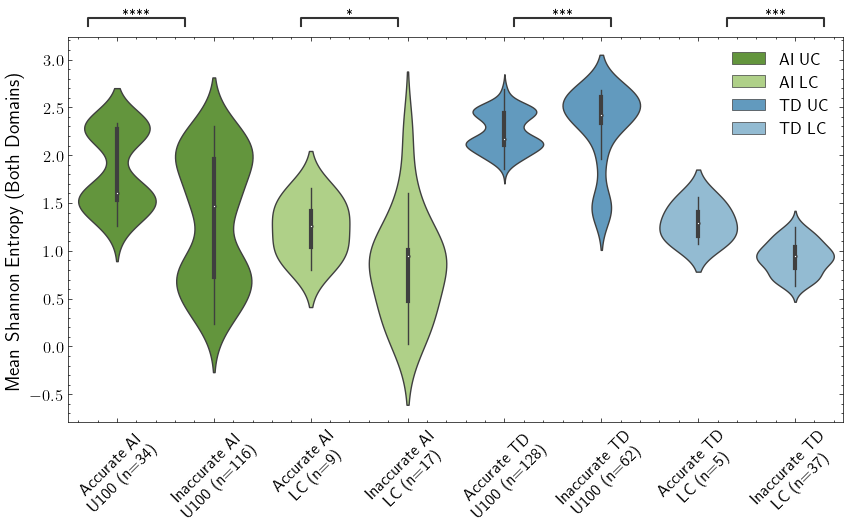

In [456]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))

order1 = [acc_ai_u100, inacc_ai_u100, acc_ai_lc, inacc_ai_lc, acc_td_u100, inacc_td_u100, acc_td_lc, inacc_td_lc]
pairs1 = [[(acc_ai_u100, 'AI UC'), (inacc_ai_u100, 'AI UC')],
          [(acc_ai_lc, 'AI LC'), (inacc_ai_lc, 'AI LC')], 
         [(acc_td_u100, 'TD UC'), (inacc_td_u100, 'TD UC')],
         [(acc_td_lc, 'TD LC'), (inacc_td_lc, 'TD LC')]]

order2 = [acc_ai_lc, inacc_ai_lc, acc_td_lc, inacc_td_lc]
pairs2 = [[(acc_ai_lc, 'AI LC'), (inacc_ai_lc, 'AI LC')],
            [(acc_td_lc, 'TD LC'), (inacc_td_lc, 'TD LC')]]

plot_lineage(both_clusters, axes, colors, 'Accuracy', 'both_reg_mean', 'Type', order1, pairs1)
# plot_lineage(non_u, axes[1], colors, 'Accuracy', 'w_mean', 'Type', order2, pairs2)
axes.set_ylabel('Mean Shannon Entropy (Both Domains)', fontsize=14)

plt.savefig('./project_pipeline/data/figures/paper/both_domains_shannon_entropy.png', dpi=1200, bbox_inches='tight')

## Local clusters with >=100 sequences

### Whole Mean

/tmp/ipykernel_1377385/2825757355.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
/home/bjechow/anaconda3/envs/analysis/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/bjechow/anaconda3/envs/analysis/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/bjechow/anaconda3/envs/analysis/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/bjec

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Accurate AI 
 LC (n=9)_AI LC vs. Inaccurate AI 
 LC (n=17)_AI LC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.059e-01 U_stat=1.070e+02
Accurate TD 
 LC (n=5)_TD LC vs. Inaccurate TD 
 LC (n=37)_TD LC: Mann-Whitney-Wilcoxon test two-sided, P_val:9.592e-04 U_stat=1.700e+02


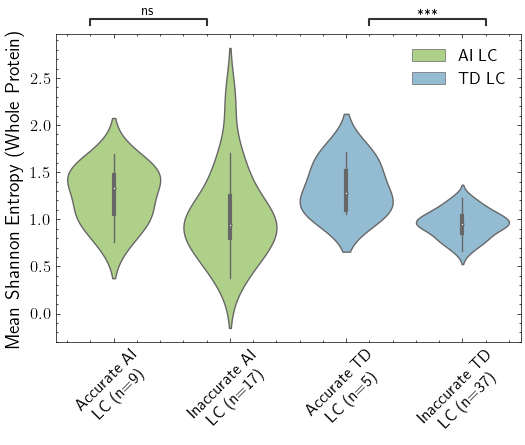

In [457]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
                         
order2 = [acc_ai_lc, inacc_ai_lc, acc_td_lc, inacc_td_lc]
pairs2 = [[(acc_ai_lc, 'AI LC'), (inacc_ai_lc, 'AI LC')],
            [(acc_td_lc, 'TD LC'), (inacc_td_lc, 'TD LC')]]

plot_lineage(non_u_100, ax, colors, 'Accuracy', 'w_mean', 'Type', order2, pairs2)
ax.set_ylabel('Mean Shannon Entropy (Whole Protein)', fontsize=14)

plt.savefig('./project_pipeline/data/figures/paper/whole_protein_shannon_entropy_lc100.png', bbox_inches='tight', dpi=1200)

### Inhibitory Module

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Accurate AI 
 LC (n=9)_AI LC vs. Inaccurate AI 
 LC (n=17)_AI LC: Mann-Whitney-Wilcoxon test two-sided, P_val:9.570e-01 U_stat=7.800e+01
Accurate TD 
 LC (n=5)_TD LC vs. Inaccurate TD 
 LC (n=37)_TD LC: Mann-Whitney-Wilcoxon test two-sided, P_val:7.618e-04 U_stat=1.710e+02


/tmp/ipykernel_1377385/2825757355.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
/home/bjechow/anaconda3/envs/analysis/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/bjechow/anaconda3/envs/analysis/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/bjechow/anaconda3/envs/analysis/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/bjec

Text(30.894262246015373, 0.5, 'Mean Shannon Entropy (IM/D1)')

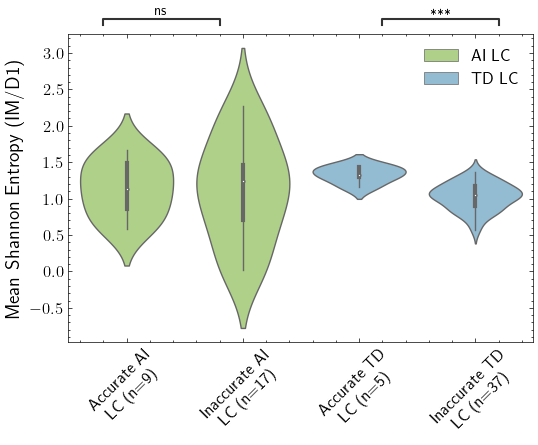

In [458]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
                         
order2 = [acc_ai_lc, inacc_ai_lc, acc_td_lc, inacc_td_lc]
pairs2 = [[(acc_ai_lc, 'AI LC'), (inacc_ai_lc, 'AI LC')],
            [(acc_td_lc, 'TD LC'), (inacc_td_lc, 'TD LC')]]

plot_lineage(non_u_100, ax, colors, 'Accuracy', 'reg1_mean', 'Type', order2, pairs2)
ax.set_ylabel('Mean Shannon Entropy (IM/D1)', fontsize=14)

### Functional Domain

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Accurate AI 
 LC (n=9)_AI LC vs. Inaccurate AI 
 LC (n=17)_AI LC: Mann-Whitney-Wilcoxon test two-sided, P_val:5.983e-03 U_stat=1.280e+02
Accurate TD 
 LC (n=5)_TD LC vs. Inaccurate TD 
 LC (n=37)_TD LC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.808e-03 U_stat=1.670e+02


/tmp/ipykernel_1377385/2825757355.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
/home/bjechow/anaconda3/envs/analysis/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/bjechow/anaconda3/envs/analysis/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/bjechow/anaconda3/envs/analysis/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/bjec

Text(30.894262246015373, 0.5, 'Mean Shannon Entropy (FD/D2)')

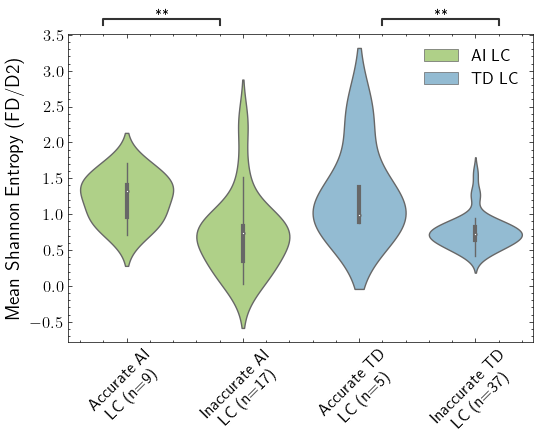

In [459]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
                         
order2 = [acc_ai_lc, inacc_ai_lc, acc_td_lc, inacc_td_lc]
pairs2 = [[(acc_ai_lc, 'AI LC'), (inacc_ai_lc, 'AI LC')],
            [(acc_td_lc, 'TD LC'), (inacc_td_lc, 'TD LC')]]

plot_lineage(non_u_100, ax, colors, 'Accuracy', 'reg2_mean', 'Type', order2, pairs2)
ax.set_ylabel('Mean Shannon Entropy (FD/D2)', fontsize=14)

### Both Regions

/tmp/ipykernel_1377385/2825757355.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
/home/bjechow/anaconda3/envs/analysis/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/bjechow/anaconda3/envs/analysis/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/bjechow/anaconda3/envs/analysis/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/bjec

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Accurate AI 
 LC (n=9)_AI LC vs. Inaccurate AI 
 LC (n=17)_AI LC: Mann-Whitney-Wilcoxon test two-sided, P_val:3.556e-02 U_stat=1.160e+02
Accurate TD 
 LC (n=5)_TD LC vs. Inaccurate TD 
 LC (n=37)_TD LC: Mann-Whitney-Wilcoxon test two-sided, P_val:5.972e-04 U_stat=1.720e+02


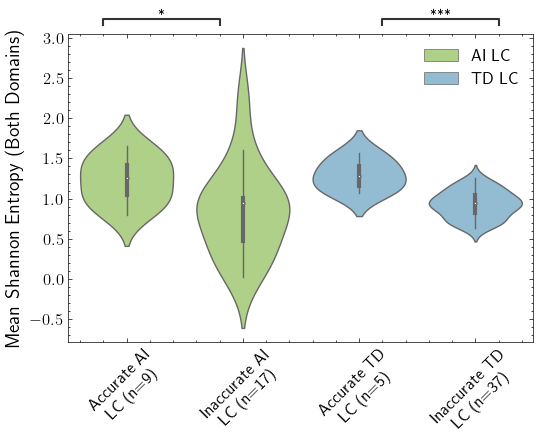

In [460]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
                         
order2 = [acc_ai_lc, inacc_ai_lc, acc_td_lc, inacc_td_lc]
pairs2 = [[(acc_ai_lc, 'AI LC'), (inacc_ai_lc, 'AI LC')],
            [(acc_td_lc, 'TD LC'), (inacc_td_lc, 'TD LC')]]

plot_lineage(non_u_100, ax, colors, 'Accuracy', 'both_reg_mean', 'Type', order2, pairs2)
ax.set_ylabel('Mean Shannon Entropy (Both Domains)', fontsize=14)

plt.savefig('./project_pipeline/data/figures/paper/both_domains_shannon_entropy_lc.png', bbox_inches='tight', dpi=1200)

### Other Regions

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Accurate AI 
 LC (n=9)_AI LC vs. Inaccurate AI 
 LC (n=17)_AI LC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.456e-01 U_stat=1.040e+02
Accurate TD 
 LC (n=5)_TD LC vs. Inaccurate TD 
 LC (n=37)_TD LC: Mann-Whitney-Wilcoxon test two-sided, P_val:6.689e-02 U_stat=1.400e+02


/tmp/ipykernel_1377385/2825757355.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
/home/bjechow/anaconda3/envs/analysis/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/bjechow/anaconda3/envs/analysis/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/bjechow/anaconda3/envs/analysis/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/bjec

Text(43.53961155459777, 0.5, 'Mean Shannon Entropy (Other Regions)')

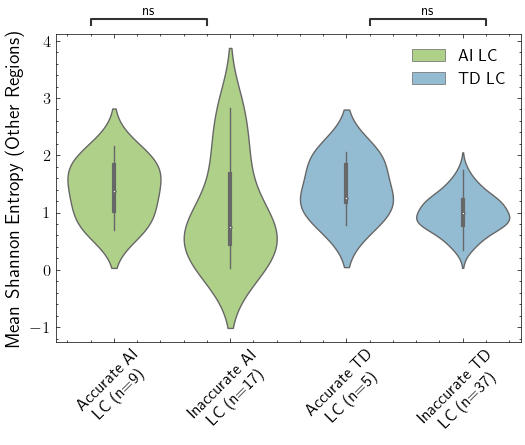

In [461]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
                         
order2 = [acc_ai_lc, inacc_ai_lc, acc_td_lc, inacc_td_lc]
pairs2 = [[(acc_ai_lc, 'AI LC'), (inacc_ai_lc, 'AI LC')],
            [(acc_td_lc, 'TD LC'), (inacc_td_lc, 'TD LC')]]

plot_lineage(non_u_100, ax, colors, 'Accuracy', 'o_reg_mean', 'Type', order2, pairs2)
ax.set_ylabel('Mean Shannon Entropy (Other Regions)', fontsize=14)

## UC Binned by Number of Sequences

### Whole Mean

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Accurate AI 
 U100 (n=34) vs. Inaccurate AI 
 U100 (n=116): Mann-Whitney-Wilcoxon test two-sided, P_val:9.662e-01 U_stat=3.139e+03
Accurate TD 
 U100 (n=128) vs. Inaccurate TD 
 U100 (n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:1.144e-05 U_stat=2.408e+03


/tmp/ipykernel_1377385/3909509559.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


(<Axes: xlabel='Accuracy', ylabel='Mean Shannon Entropy (Whole Protein)'>,
  <statannotations.Annotation.Annotation at 0x7f7cf9c0fa90>])

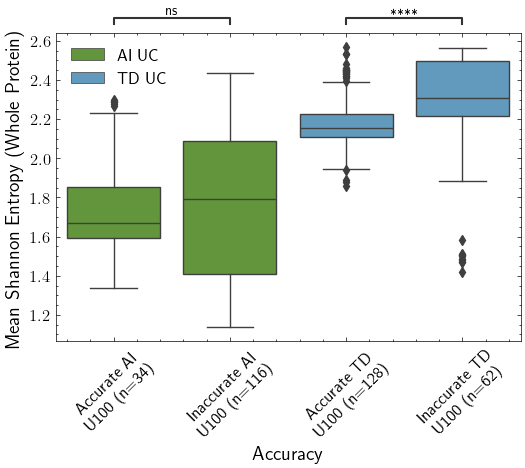

In [462]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# axes[0].set_ylim(0, 50)
# axes[1].set_ylim(0, 50)

order1 = [acc_ai_u100, inacc_ai_u100, acc_td_u100, inacc_td_u100]
pairs1 = [[(acc_ai_u100), (inacc_ai_u100)],
            [(acc_td_u100), (inacc_td_u100)]]

# order2 = ['Accurate TD U10', 'Inaccurate TD U10', ]
# pairs2 = [[('Accurate TD U10'), ('Inaccurate TD U10')],
#             [('Accurate TD U100'), ('Inaccurate TD U100')]]

# plot_lineage(acc_both_only_u, axes[0], colors, 'Type', 'Mean LS', 'Type', order, pairs)
# plot_lineage(only_u, axes[0], accuracy_palette, 'Type', 'Mean LS', 'Accuracy', order, pairs)
sns.boxplot(x='Accuracy', y='w_mean', data=only_100, ax=ax, hue='Type', palette=colors, dodge=False)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.set_ylabel('Mean Shannon Entropy (Whole Protein)', fontsize=14)
ax.set_xlabel('Accuracy', fontsize=14)
ax.legend(title_fontsize='14', fontsize='12')

annotator = Annotator(ax, pairs1, data=only_100, x='Accuracy', y='w_mean', order=order1)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

### IM Shannon Entropy

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Accurate AI 
 U100 (n=34) vs. Inaccurate AI 
 U100 (n=116): Mann-Whitney-Wilcoxon test two-sided, P_val:1.215e-02 U_stat=3.896e+03
Accurate TD 
 U100 (n=128) vs. Inaccurate TD 
 U100 (n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:9.219e-02 U_stat=3.369e+03


/tmp/ipykernel_1377385/598143149.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


(<Axes: xlabel='Accuracy', ylabel='Mean Shannon Entropy (IM/D1)'>,
  <statannotations.Annotation.Annotation at 0x7f7cf9dda410>])

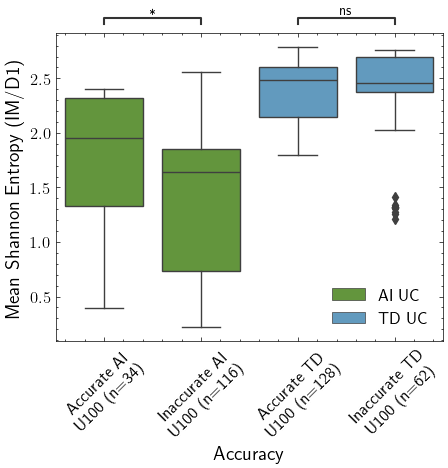

In [463]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

order1 = [acc_ai_u100, inacc_ai_u100, acc_td_u100, inacc_td_u100]
pairs1 = [[(acc_ai_u100), (inacc_ai_u100)],
            [(acc_td_u100), (inacc_td_u100)]]

sns.boxplot(x='Accuracy', y='reg1_mean', data=only_100, ax=ax, hue='Type', palette=colors, dodge=False)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.set_ylabel('Mean Shannon Entropy (IM/D1)', fontsize=14)
ax.set_xlabel('Accuracy', fontsize=14)
ax.legend(title_fontsize='14', fontsize='12')

annotator = Annotator(ax, pairs1, data=only_100, x='Accuracy', y='reg1_mean', order=order1)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

### FD Shannon Entropy

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Accurate AI 
 U100 (n=34) vs. Inaccurate AI 
 U100 (n=116): Mann-Whitney-Wilcoxon test two-sided, P_val:4.071e-05 U_stat=4.386e+03
Accurate TD 
 U100 (n=128) vs. Inaccurate TD 
 U100 (n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:2.258e-01 U_stat=4.399e+03


/tmp/ipykernel_1377385/1775534193.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


(<Axes: xlabel='Accuracy', ylabel='Mean Shannon Entropy (FD/D2)'>,
  <statannotations.Annotation.Annotation at 0x7f7cf9bda9d0>])

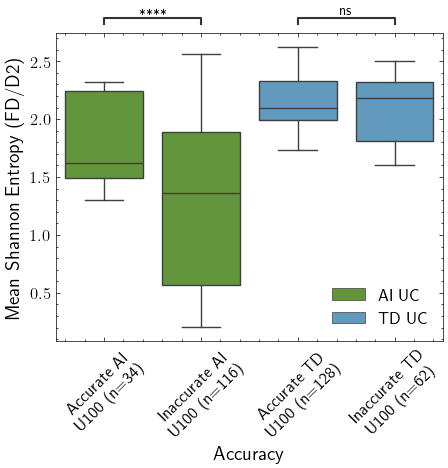

In [464]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

order1 = [acc_ai_u100, inacc_ai_u100, acc_td_u100, inacc_td_u100]
pairs1 = [[(acc_ai_u100), (inacc_ai_u100)],
            [(acc_td_u100), (inacc_td_u100)]]

sns.boxplot(x='Accuracy', y='reg2_mean', data=only_100, ax=ax, hue='Type', palette=colors, dodge=False)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.set_ylabel('Mean Shannon Entropy (FD/D2)', fontsize=14)
ax.set_xlabel('Accuracy', fontsize=14)
ax.legend(title_fontsize='14', fontsize='12')

annotator = Annotator(ax, pairs1, data=only_100, x='Accuracy', y='reg2_mean', order=order1)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

### Both Domains Shannon Entropy

/tmp/ipykernel_1377385/3696652860.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Accurate AI 
 U100 (n=34) vs. Inaccurate AI 
 U100 (n=116): Mann-Whitney-Wilcoxon test two-sided, P_val:5.375e-06 U_stat=4.523e+03
Accurate TD 
 U100 (n=128) vs. Inaccurate TD 
 U100 (n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:4.433e-04 U_stat=2.719e+03


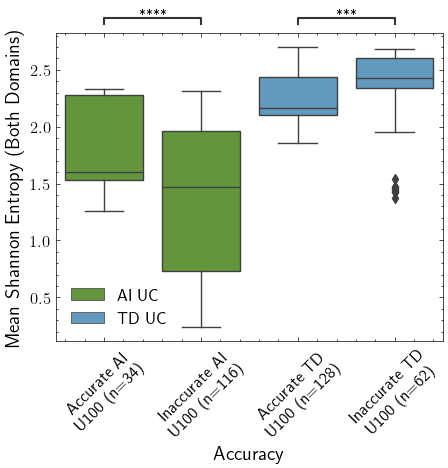

In [465]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

order1 = [acc_ai_u100, inacc_ai_u100, acc_td_u100, inacc_td_u100]
pairs1 = [[(acc_ai_u100), (inacc_ai_u100)],
            [(acc_td_u100), (inacc_td_u100)]]

sns.boxplot(x='Accuracy', y='both_reg_mean', data=only_100, ax=ax, hue='Type', palette=colors, dodge=False)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.set_ylabel('Mean Shannon Entropy (Both Domains)', fontsize=14)
ax.set_xlabel('Accuracy', fontsize=14)
ax.legend(title_fontsize='14', fontsize='12')

annotator = Annotator(ax, pairs1, data=only_100, x='Accuracy', y='both_reg_mean', order=order1)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/paper/both_domains_shannon_entropy_u100.png', bbox_inches='tight', dpi=1200)

### Other Regions Shannon Entropy

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Accurate AI 
 U100 (n=34) vs. Inaccurate AI 
 U100 (n=116): Mann-Whitney-Wilcoxon test two-sided, P_val:4.697e-02 U_stat=2.515e+03
Accurate TD 
 U100 (n=128) vs. Inaccurate TD 
 U100 (n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:2.205e-18 U_stat=7.077e+03


/tmp/ipykernel_1377385/646690294.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


(<Axes: xlabel='Accuracy', ylabel='Mean Shannon Entropy (Other Regions)'>,
  <statannotations.Annotation.Annotation at 0x7f7cf9769190>])

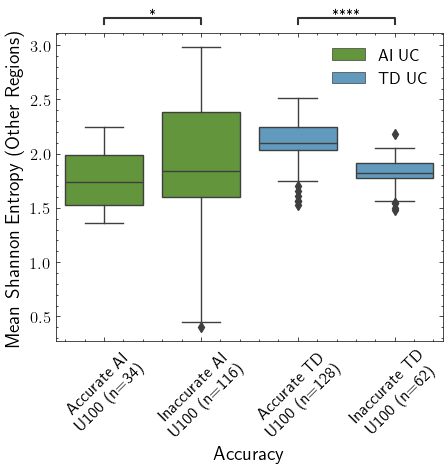

In [466]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

order1 = [acc_ai_u100, inacc_ai_u100, acc_td_u100, inacc_td_u100]
pairs1 = [[(acc_ai_u100), (inacc_ai_u100)],
            [(acc_td_u100), (inacc_td_u100)]]

sns.boxplot(x='Accuracy', y='o_reg_mean', data=only_100, ax=ax, hue='Type', palette=colors, dodge=False)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.set_ylabel('Mean Shannon Entropy (Other Regions)', fontsize=14)
ax.set_xlabel('Accuracy', fontsize=14)
ax.legend(title_fontsize='14', fontsize='12')

annotator = Annotator(ax, pairs1, data=only_100, x='Accuracy', y='o_reg_mean', order=order1)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

### Number of Sequences

In [467]:
only_u['Accuracy'].unique()

array(['Accurate AI \n (n=63)', 'Inaccurate AI \n (n=237)',
       'Accurate TD \n (n=208)', 'Inaccurate TD \n (n=171)'], dtype=object)

/tmp/ipykernel_1377385/2825757355.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Accurate AI 
 (n=63)_AI UC vs. Inaccurate AI 
 (n=237)_AI UC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.383e-02 U_stat=1.240e+04
Accurate TD 
 (n=208)_TD UC vs. Inaccurate TD 
 (n=171)_TD UC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.302e-06 U_stat=2.233e+04


/tmp/ipykernel_1377385/2825757355.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Accurate AI 
 LC (n=9)_AI LC vs. Inaccurate AI 
 LC (n=17)_AI LC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.807e-17 U_stat=3.484e+04
Accurate TD 
 LC (n=5)_TD LC vs. Inaccurate TD 
 LC (n=37)_TD LC: Mann-Whitney-Wilcoxon test two-sided, P_val:9.642e-06 U_stat=1.036e+05


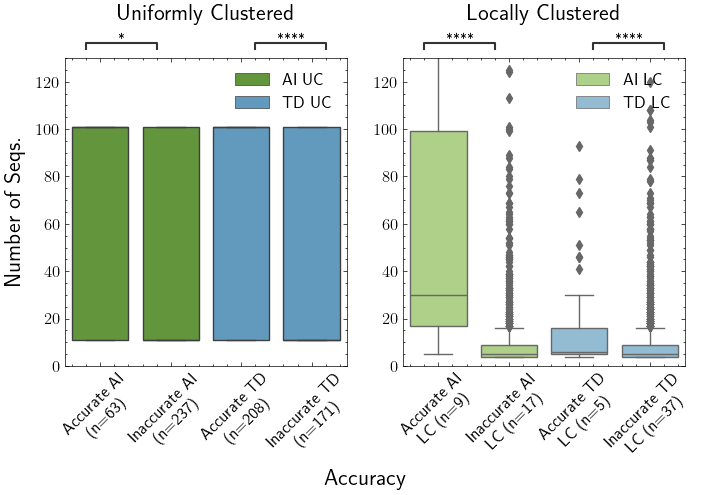

In [468]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].set_ylim(0, 130)
axes[1].set_ylim(0, 130)

axi = axes.flatten()

order1 = [acc_ai_uc, inacc_ai_uc, acc_td_uc, inacc_td_uc]
pairs1 = [[(acc_ai_uc, 'AI UC'), (inacc_ai_uc, 'AI UC')], 
         [(acc_td_uc, 'TD UC'), (inacc_td_uc, 'TD UC')]]

order2 = [acc_ai_lc, inacc_ai_lc, acc_td_lc, inacc_td_lc]
pairs2 = [[(acc_ai_lc, 'AI LC'), (inacc_ai_lc, 'AI LC')],
            [(acc_td_lc, 'TD LC'), (inacc_td_lc, 'TD LC')]]

# plot_lineage(acc_both_only_u, axes[0], colors, 'Type', 'Mean LS', 'Type', order, pairs)
# plot_lineage(only_u, axes[0], accuracy_palette, 'Type', 'Mean LS', 'Accuracy', order, pairs)
plot_normal_lineage(only_u, axes[0], colors, 'Accuracy', 'nseq', 'Type', order1, pairs1)
plot_normal_lineage(non_u, axes[1], colors, 'Accuracy', 'nseq', 'Type', order2, pairs2)

cols = ['Uniformly Clustered', 'Locally Clustered']

pad = 5
for ax, col in zip(axes, cols):
    ax.annotate(col, xy=(0.5, 1.1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=16, ha='center', va='baseline')
    
fig.supylabel('Number of Seqs.', fontsize=16, x=0.05)

fig.supxlabel('Accuracy', fontsize=16, y=-0.2)
    
plt.savefig('./project_pipeline/data/figures/paper/num_seqs.png', dpi=1200, bbox_inches='tight')

## Lineage Scores

In [469]:
only_u['uniprot'].nunique()

37

### LS Var

/tmp/ipykernel_1377385/2825757355.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Accurate AI 
 (n=63)_AI UC vs. Inaccurate AI 
 (n=237)_AI UC: Mann-Whitney-Wilcoxon test two-sided, P_val:2.661e-05 U_stat=1.406e+04
Accurate TD 
 (n=208)_TD UC vs. Inaccurate TD 
 (n=171)_TD UC: Mann-Whitney-Wilcoxon test two-sided, P_val:3.632e-01 U_stat=1.690e+04


/tmp/ipykernel_1377385/2825757355.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Accurate AI 
 LC (n=9)_AI LC vs. Inaccurate AI 
 LC (n=17)_AI LC: Mann-Whitney-Wilcoxon test two-sided, P_val:8.688e-10 U_stat=3.036e+04
Accurate TD 
 LC (n=5)_TD LC vs. Inaccurate TD 
 LC (n=37)_TD LC: Mann-Whitney-Wilcoxon test two-sided, P_val:2.858e-01 U_stat=7.761e+04


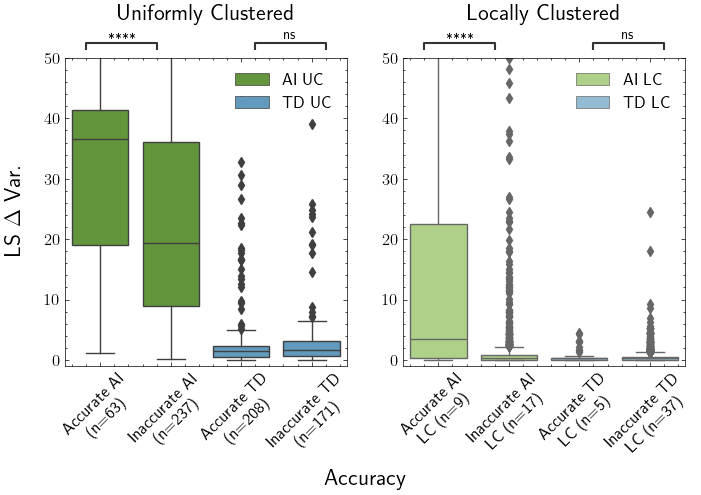

In [470]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].set_ylim(-1, 50)
axes[1].set_ylim(-1, 50)

axi = axes.flatten()

order1 = [acc_ai_uc, inacc_ai_uc, acc_td_uc, inacc_td_uc]
pairs1 = [[(acc_ai_uc, 'AI UC'), (inacc_ai_uc, 'AI UC')], 
         [(acc_td_uc, 'TD UC'), (inacc_td_uc, 'TD UC')]]

order2 = [acc_ai_lc, inacc_ai_lc, acc_td_lc, inacc_td_lc]
pairs2 = [[(acc_ai_lc, 'AI LC'), (inacc_ai_lc, 'AI LC')],
            [(acc_td_lc, 'TD LC'), (inacc_td_lc, 'TD LC')]]

# plot_lineage(acc_both_only_u, axes[0], colors, 'Type', 'Mean LS', 'Type', order, pairs)
# plot_lineage(only_u, axes[0], accuracy_palette, 'Type', 'Mean LS', 'Accuracy', order, pairs)
plot_normal_lineage(only_u, axes[0], colors, 'Accuracy', 'LS $\Delta$ Var.', 'Type', order1, pairs1)
plot_normal_lineage(non_u, axes[1], colors, 'Accuracy', 'LS $\Delta$ Var.', 'Type', order2, pairs2)

cols = ['Uniformly Clustered', 'Locally Clustered']

pad = 5
for ax, col in zip(axes, cols):
    ax.annotate(col, xy=(0.5, 1.1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=16, ha='center', va='baseline')
    

fig.supylabel('LS $\Delta$ Var.', fontsize=16, x=0.05)

fig.supxlabel('Accuracy', fontsize=16, y=-0.2)
    
plt.savefig('./project_pipeline/data/figures/paper/ls_var.png', dpi=1200, bbox_inches='tight')

/tmp/ipykernel_1377385/2825757355.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Accurate AI 
 U10 (n=23) vs. Inccurate AI 
 U10 (n=127): Mann-Whitney-Wilcoxon test two-sided, P_val:1.554e-01 U_stat=2.488e+03
Accurate AI 
 U100 (n=34) vs. Inaccurate AI 
 U100 (n=116): Mann-Whitney-Wilcoxon test two-sided, P_val:3.484e-05 U_stat=4.397e+03


/tmp/ipykernel_1377385/2825757355.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Accurate TD 
 U10 (n=81) vs. Inaccurate TD 
 U10 (n=109): Mann-Whitney-Wilcoxon test two-sided, P_val:1.964e-01 U_stat=4.840e+03
Accurate TD 
 U100 (n=128) vs. Inaccurate TD 
 U100 (n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:1.461e-05 U_stat=2.427e+03


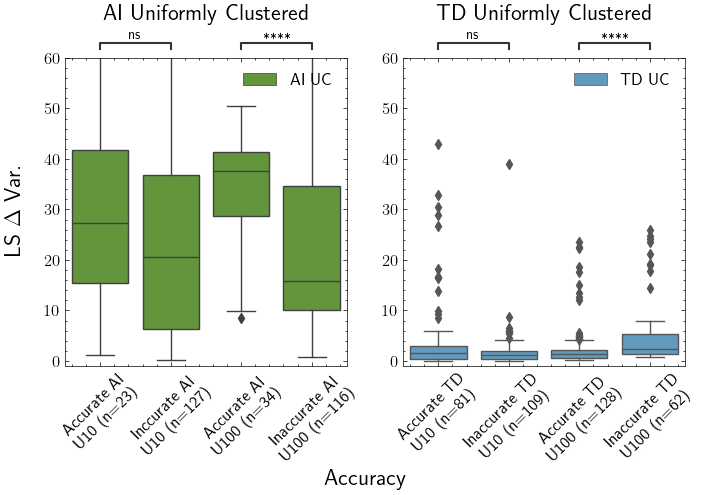

In [471]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].set_ylim(-1, 60)
axes[1].set_ylim(-1, 60)

axi = axes.flatten()

order1 = [acc_ai_u10, inacc_ai_u10, acc_ai_u100, inacc_ai_u100]
pairs1 = [[(acc_ai_u10), (inacc_ai_u10)],
            [(acc_ai_u100), (inacc_ai_u100)]]

order2 = [acc_td_u10, inacc_td_u10, acc_td_u100, inacc_td_u100]
pairs2 = [[(acc_td_u10), (inacc_td_u10)],
            [(acc_td_u100), (inacc_td_u100)]]

# plot_lineage(acc_both_only_u, axes[0], colors, 'Type', 'Mean LS', 'Type', order, pairs)
# plot_lineage(only_u, axes[0], accuracy_palette, 'Type', 'Mean LS', 'Accuracy', order, pairs)
plot_normal_lineage(broken_down_by_u_ai, axes[0], colors, 'Accuracy', 'LS $\Delta$ Var.', 'Type', order1, pairs1, include_hue=False)
plot_normal_lineage(broken_down_by_u_md, axes[1], colors, 'Accuracy', 'LS $\Delta$ Var.', 'Type', order2, pairs2, include_hue=False)

cols = ['AI Uniformly Clustered', 'TD Uniformly Clustered']

pad = 5
for ax, col in zip(axes, cols):
    ax.annotate(col, xy=(0.5, 1.1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=16, ha='center', va='baseline')
    
fig.supxlabel('Accuracy', fontsize=16, y=-0.2)
fig.supylabel('LS $\Delta$ Var.', fontsize=16, x=0.05)
    
plt.savefig('./project_pipeline/data/figures/paper/ls_var_binned.png', dpi=300, bbox_inches='tight')

### LS Max

/tmp/ipykernel_1377385/2825757355.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Accurate AI 
 (n=63)_AI UC vs. Inaccurate AI 
 (n=237)_AI UC: Mann-Whitney-Wilcoxon test two-sided, P_val:2.909e-09 U_stat=1.544e+04
Accurate TD 
 (n=208)_TD UC vs. Inaccurate TD 
 (n=171)_TD UC: Mann-Whitney-Wilcoxon test two-sided, P_val:2.015e-01 U_stat=1.922e+04


/tmp/ipykernel_1377385/2825757355.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Accurate AI 
 LC (n=9)_AI LC vs. Inaccurate AI 
 LC (n=17)_AI LC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.140e-06 U_stat=2.844e+04
Accurate TD 
 LC (n=5)_TD LC vs. Inaccurate TD 
 LC (n=37)_TD LC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.871e-02 U_stat=7.166e+04


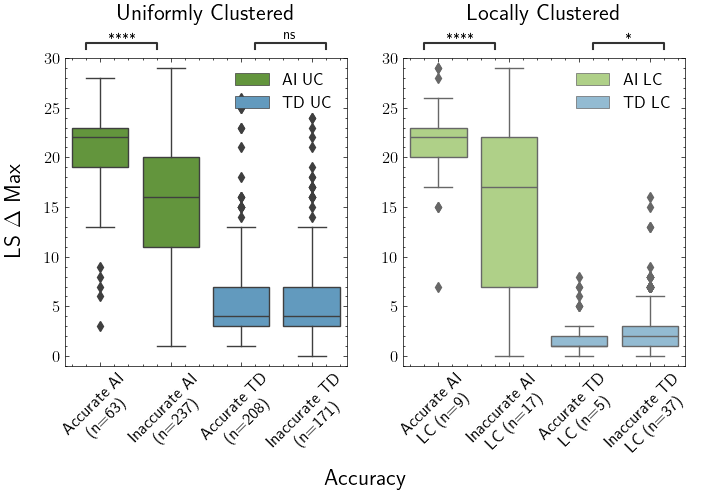

In [472]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].set_ylim(-1, 30)
axes[1].set_ylim(-1, 30)

axi = axes.flatten()

order1 = [acc_ai_uc, inacc_ai_uc, acc_td_uc, inacc_td_uc]
pairs1 = [[(acc_ai_uc, 'AI UC'), (inacc_ai_uc, 'AI UC')], 
         [(acc_td_uc, 'TD UC'), (inacc_td_uc, 'TD UC')]]

order2 = [acc_ai_lc, inacc_ai_lc, acc_td_lc, inacc_td_lc]
pairs2 = [[(acc_ai_lc, 'AI LC'), (inacc_ai_lc, 'AI LC')],
            [(acc_td_lc, 'TD LC'), (inacc_td_lc, 'TD LC')]]

# plot_lineage(acc_both_only_u, axes[0], colors, 'Type', 'Mean LS', 'Type', order, pairs)
# plot_lineage(only_u, axes[0], accuracy_palette, 'Type', 'Mean LS', 'Accuracy', order, pairs)
plot_normal_lineage(only_u, axes[0], colors, 'Accuracy', 'LS $\Delta$ Max', 'Type', order1, pairs1, include_hue=True)
plot_normal_lineage(non_u, axes[1], colors, 'Accuracy', 'LS $\Delta$ Max', 'Type', order2, pairs2, include_hue=True)

cols = ['Uniformly Clustered', 'Locally Clustered']

pad = 5
for ax, col in zip(axes, cols):
    ax.annotate(col, xy=(0.5, 1.1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=16, ha='center', va='baseline')
    
fig.supxlabel('Accuracy', fontsize=16, y=-0.2)
fig.supylabel('LS $\Delta$ Max', fontsize=16, x=0.05)
    
plt.savefig('./project_pipeline/data/figures/paper/ls_max.png', dpi=1200, bbox_inches='tight')

/tmp/ipykernel_1377385/2825757355.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Accurate AI 
 U10 (n=23) vs. Inccurate AI 
 U10 (n=127): Mann-Whitney-Wilcoxon test two-sided, P_val:2.144e-02 U_stat=2.710e+03
Accurate AI 
 U100 (n=34) vs. Inaccurate AI 
 U100 (n=116): Mann-Whitney-Wilcoxon test two-sided, P_val:3.034e-07 U_stat=4.694e+03


/tmp/ipykernel_1377385/2825757355.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Accurate TD 
 U10 (n=81) vs. Inaccurate TD 
 U10 (n=109): Mann-Whitney-Wilcoxon test two-sided, P_val:3.109e-01 U_stat=4.788e+03
Accurate TD 
 U100 (n=128) vs. Inaccurate TD 
 U100 (n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:6.527e-05 U_stat=2.559e+03


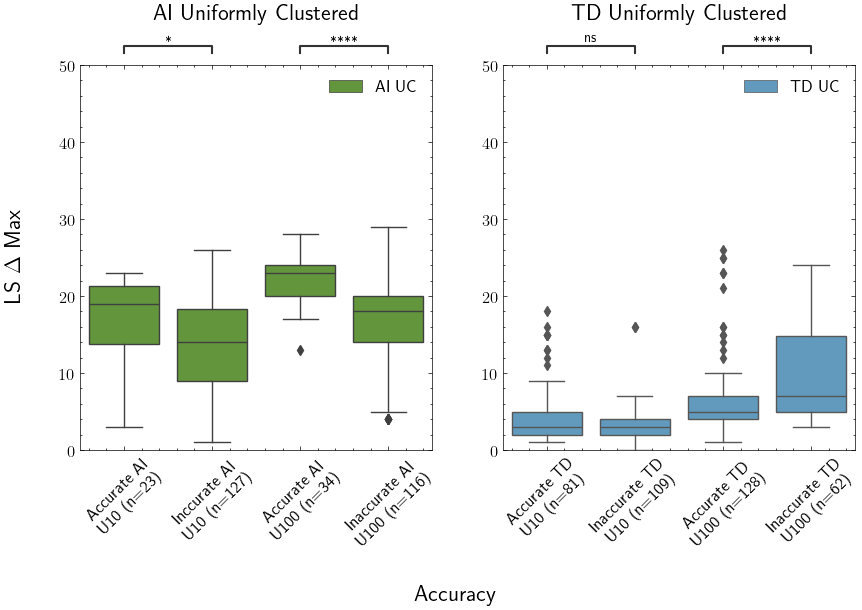

In [473]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_ylim(0, 50)
axes[1].set_ylim(0, 50)

axi = axes.flatten()

order1 = [acc_ai_u10, inacc_ai_u10, acc_ai_u100, inacc_ai_u100]
pairs1 = [[(acc_ai_u10), (inacc_ai_u10)],
            [(acc_ai_u100), (inacc_ai_u100)]]

order2 = [acc_td_u10, inacc_td_u10, acc_td_u100, inacc_td_u100]
pairs2 = [[(acc_td_u10), (inacc_td_u10)],
            [(acc_td_u100), (inacc_td_u100)]]

plot_normal_lineage(broken_down_by_u_ai, axes[0], colors, 'Accuracy', 'LS $\Delta$ Max', 'Type', order1, pairs1, include_hue=False)
plot_normal_lineage(broken_down_by_u_md, axes[1], colors, 'Accuracy', 'LS $\Delta$ Max', 'Type', order2, pairs2, include_hue=False)

cols = ['AI Uniformly Clustered', 'TD Uniformly Clustered']

pad = 5
for ax, col in zip(axes, cols):
    ax.annotate(col, xy=(0.5, 1.1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=16, ha='center', va='baseline')
    
fig.supxlabel('Accuracy', fontsize=16, y=-0.2)
fig.supylabel('LS $\Delta$ Max', fontsize=16, x=0.05)
    
plt.savefig('./project_pipeline/data/figures/paper/ls_max_binned.png', dpi=500, bbox_inches='tight')